# FFI $S/N$ summary

Basic animation of the FFI data process.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [2]:
from astropy.io import fits
import astropy.visualization
from fast_histogram import histogram1d

In [3]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

Campaign 13 is the most recent campaign we have available.  
Let's download it from the [K2 FFI MAST portal](https://archive.stsci.edu/pub/k2/ffi/).  We'll get both the FFI itself and its `unc` companion file.

In [7]:
hdu = fits.open('/Volumes/Truro/ffi/ktwo2017079075530-c13_ffi-cal.fits')

In [8]:
#hdu.info()

The FFIs are comprised of many individual modules and channels, etc.  Let's look at one of them.  Module 13 is near "on-axis" of the optical system: it's in the middle of the field of view and should therefore have better-than-average image quality.

In [9]:
mod13p1 = hdu['MOD.OUT 13.2']

Negative values foil logarithmic transformations.  Add a bias value of 500.0

In [10]:
dat = mod13p1.data
data = dat[270:-50, 270:-50]
logdat = np.log10(data)

In [11]:
minmax = astropy.visualization.MinMaxInterval()

vmin, vmax = minmax.get_limits(logdat)

x = np.linspace(vmin, vmax, 200)
y = histogram1d(logdat.reshape(-1), bins=200, range=(vmin, vmax))

Let's improve the *screen stretch* for readability.

In [12]:
good_interval = astropy.visualization.AsymmetricPercentileInterval(10, 95.0)
vmin, vmax = good_interval.get_limits(logdat)

In [13]:
norm = astropy.visualization.ImageNormalize(vmin=10**vmin, vmax=10**vmax)

In [14]:
exptime_day = hdu[1].header['EXPOSURE'] # exposure time in DAYS

In [15]:
exptime_sec = exptime_day*24.0*60.0*60.0 

In [16]:
exptime_sec

1625.34384

In [17]:
hdu[1].header['BUNIT'], hdu[1].header['READNOIS'] # Read noise has units of ELECTRONS.

('electrons/s', 87.604748)

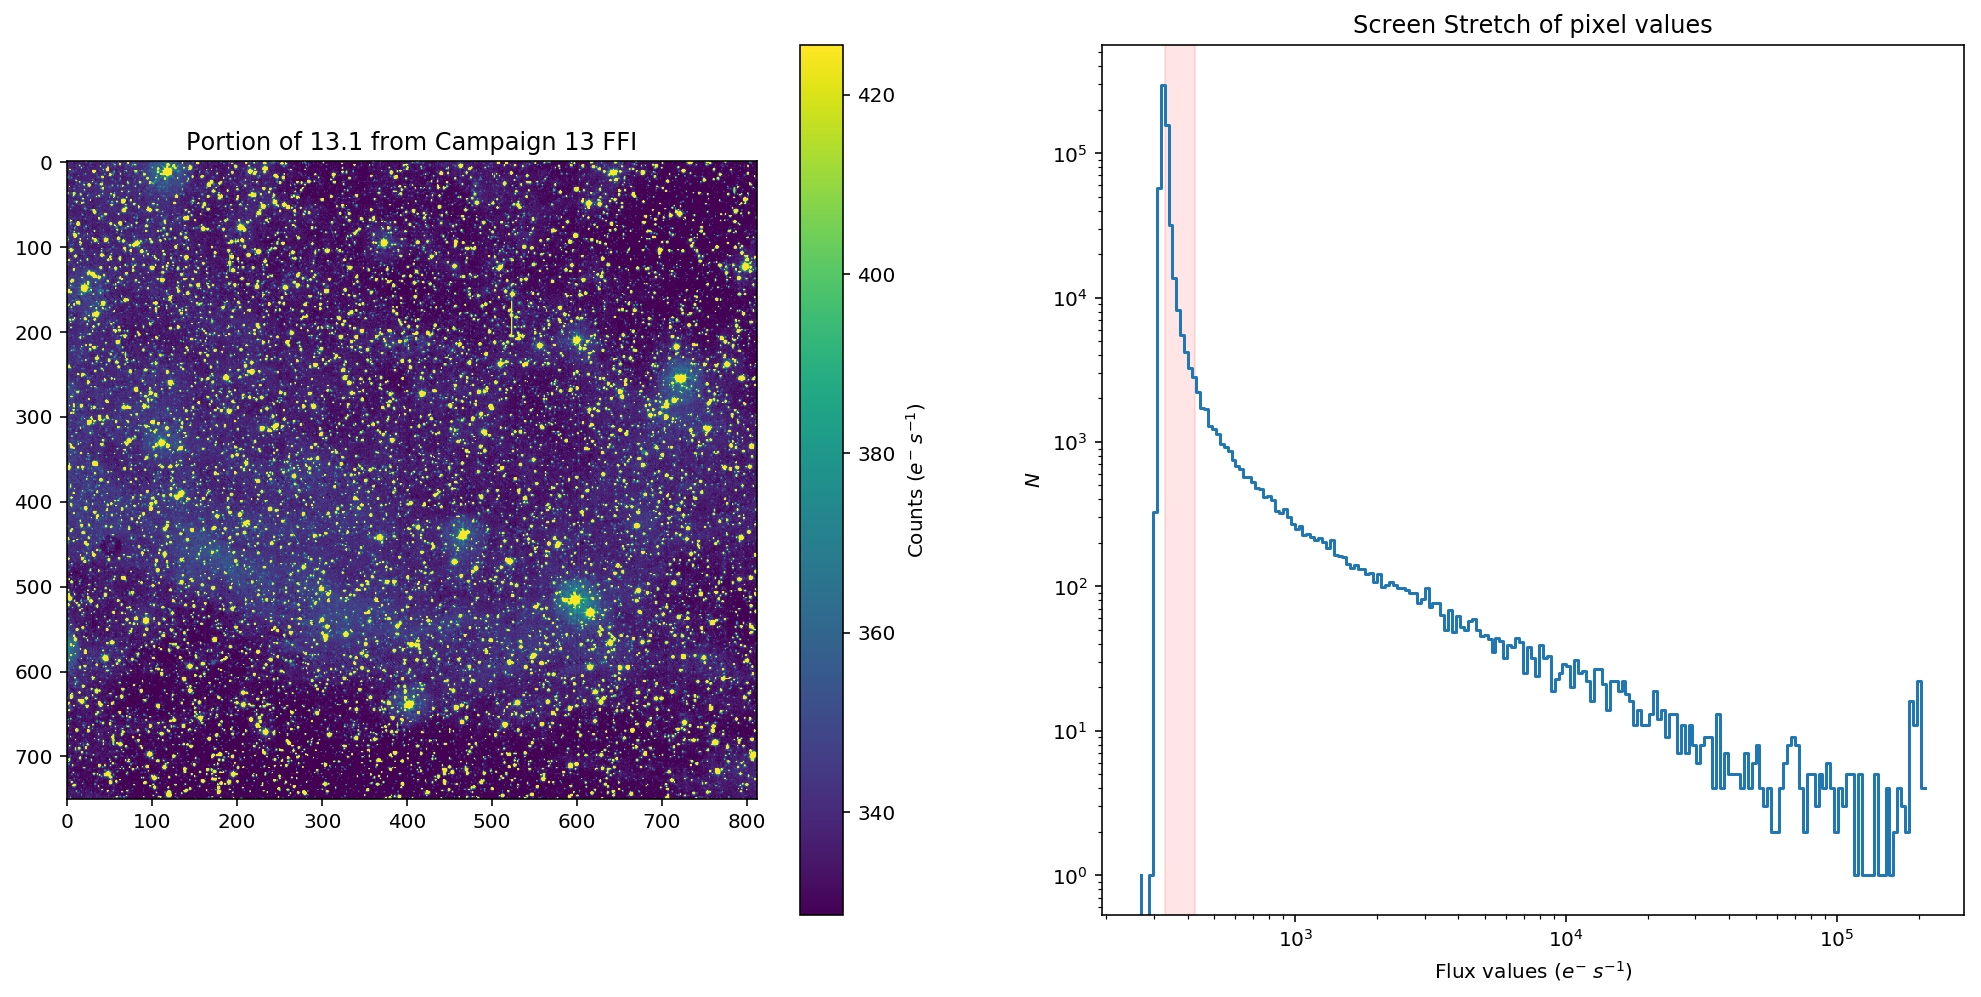

In [18]:
plt.figure(figsize=(17,8))

plt.subplot(121)
plt.imshow(data, norm=norm)
plt.title('Portion of 13.1 from Campaign 13 FFI')
cbar = plt.colorbar()
cbar.set_label('Counts ($e^{-} \; s^{-1}$)')

plt.subplot(122)
plt.step(10**x, y)
plt.axvspan(10**vmin, 10**vmax, alpha=0.1, color='r')
plt.yscale('log')
plt.xscale('log')
plt.xlabel('Flux values ($e^{-} \; s^{-1}$)')
plt.ylabel('$N$')
plt.title('Screen Stretch of pixel values');
#plt.savefig('demo_FFI_13p2_data.png', dpi=300, bbox_inches='tight');

There is some weak structure in the background apparent at this screen stretch.  The background structure must dominate the RMS estimate of readnoise-- the background is not flat enough to assume that the width of the above distribution is the readnoise.

In [19]:
from astropy.stats import sigma_clipped_stats
from photutils import make_source_mask
from astropy.stats import SigmaClip
from photutils import Background2D, MedianBackground, ModeEstimatorBackground

Estimate the background with sigma clipping:

In [20]:
mean_est1, median_est1, std_est1 = sigma_clipped_stats(data, sigma=3.0, iters=5)
print((mean_est1, median_est1, std_est1))

(337.96021267870117, 336.82403564453125, 8.776299309081983)


Estimate the background with source masking:

In [19]:
mask = make_source_mask(data, snr=2, npixels=5, dilate_size=11)
mean_est2, median_est2, std_est2 = sigma_clipped_stats(data, sigma=3.0, mask=mask)
print((mean_est2, median_est2, std_est2))    

(333.93184319380669, 333.72601318359375, 6.0500723992281662)


The background has some structure to it, so let's experiment with a 2D background.

In [20]:
sigma_clip = SigmaClip(sigma=3.0, iters=10)
bkg = Background2D(data, (21, 21), filter_size=(5, 5),sigma_clip=sigma_clip)

In [21]:
bkg.background_median, bkg.background_rms_median

(336.24198380220957, 3.4881471625042706)

The final background RMS median is $\sim3.5 \; e^{-}/s$.  That means the *per read* RMS must be a factor of $\sqrt{270}$ *less*:

In [22]:
RN_per_read = 3.5 / np.sqrt(270)
RN_per_read

0.21300321680756462

In units of electrons per second.  The FITS header claims 87.6 *electrons* readnoise.

In [23]:
87.6/exptime_sec

0.05389628818478187

Which is lower by a factor of 4 than my estimate.  It could be that the RMS is *still* dominated by residual background structure, and the background has a finite contribution to the photon shot noise.

In [24]:
good_interval = astropy.visualization.AsymmetricPercentileInterval(10, 95.0)
vmin, vmax = good_interval.get_limits(np.log10(bkg.background))

In [25]:
new_norm = astropy.visualization.ImageNormalize(vmin=10**vmin, vmax=10**vmax)

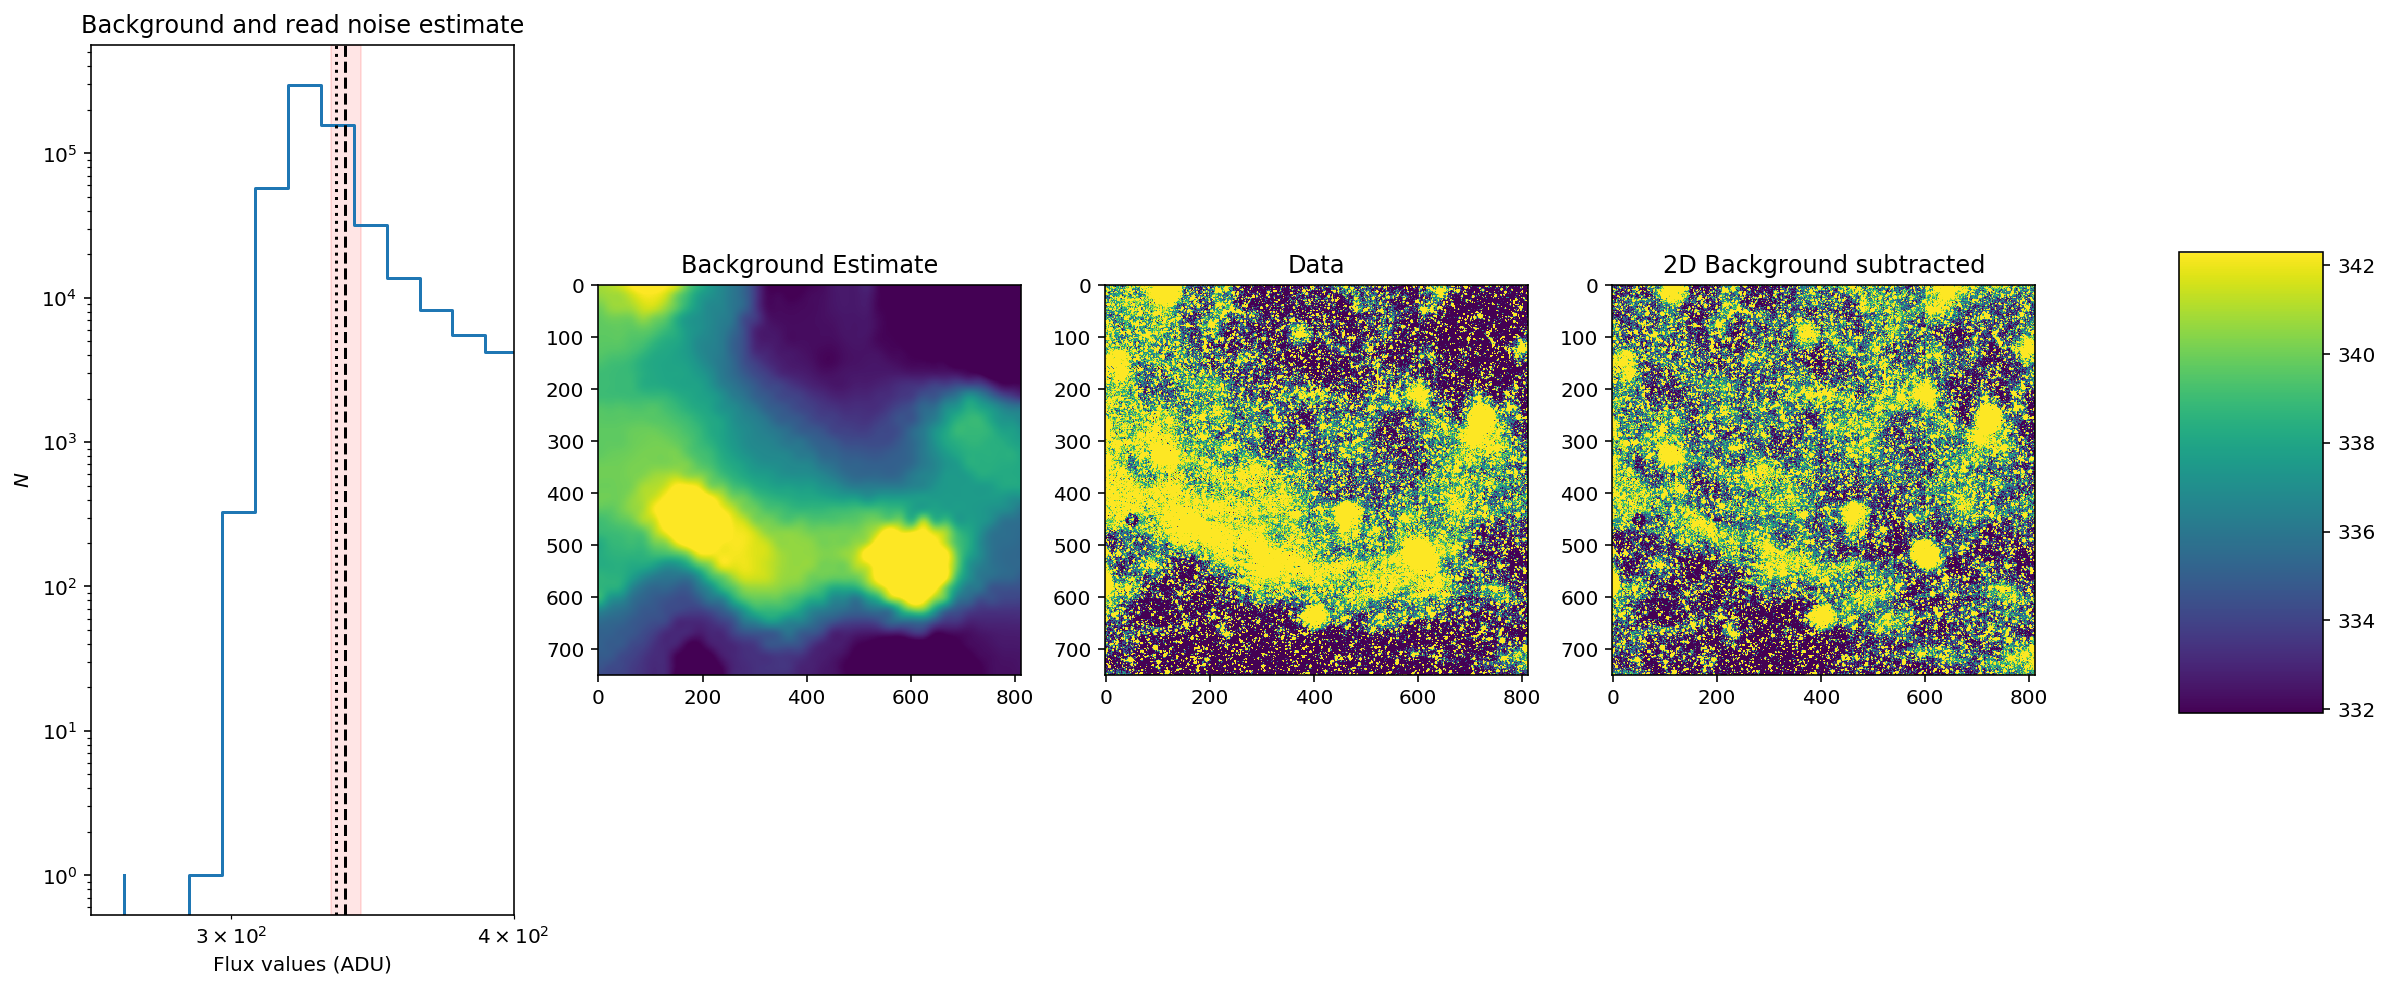

In [26]:
fig = plt.figure(figsize=(20,8))
plt.subplot(141)
plt.step(10**x, y)
plt.axvspan(10**vmin, 10**vmax, alpha=0.1, color='r')
plt.axvline(833.7, color='k', linestyle='dashed')
plt.yscale('log')
plt.xscale('log')

plt.axvline(median_est1, color='k', linestyle='dashed')
plt.axvline(median_est2, color='k', linestyle='dotted')
plt.xlabel('Flux values (ADU)')
plt.ylabel('$N$')
plt.title('Background and read noise estimate')
plt.xlim(2.6E2, 4.0E2)

plt.subplot(142)
plt.imshow(bkg.background, norm=new_norm)
plt.title('Background Estimate')
plt.subplot(143)
im= plt.imshow(data, norm=new_norm)
plt.title('Data')
plt.subplot(144)
plt.imshow(data-bkg.background+bkg.background_median, norm=new_norm)
plt.title('2D Background subtracted')
fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.3, 0.05, 0.4])
fig.colorbar(im, cax=cbar_ax);

Cool!

In [27]:
dim_x, dim_y = data.shape

In [28]:
flat_bkg = 0.0 + 3.5*np.random.randn(dim_x, dim_y)

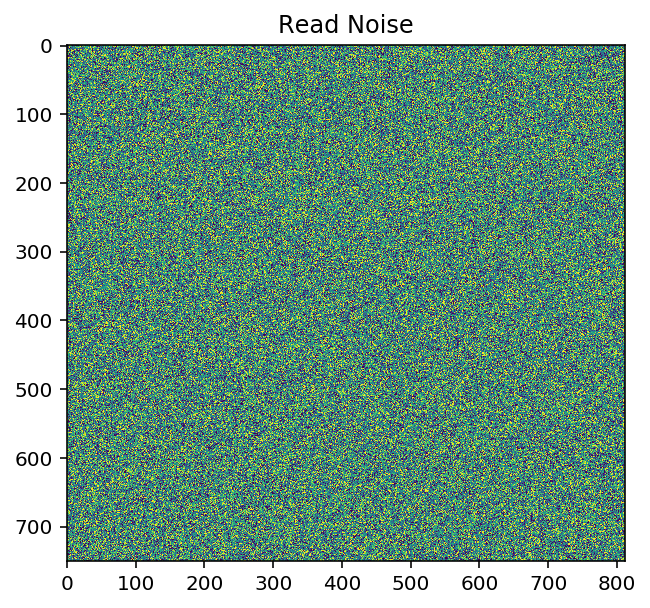

In [29]:
plt.figure(figsize=(5,5))
plt.imshow(337+flat_bkg, norm=new_norm)
plt.title('Read Noise')
#plt.savefig('demo_FFI_13p2_data.png', dpi=300, bbox_inches='tight');

## Poisson noise

What matters is the 6-second reads, so we will background subtract the data, divide by 270, and use that as a mean *rate parameter*.

In [30]:
from scipy.stats import poisson

In [70]:
rate = (dat - 336.0)
rate_mu = np.abs(rate / 270.0)

In [33]:
pois_noise = poisson.rvs(rate_mu)

In [34]:
vals = np.sqrt(np.abs(rate_mu))/np.std(flat_bkg)
vmin, vmax = np.min(vals), np.max(vals)
x = np.linspace(vmin, vmax, 200)
y = histogram1d(vals.reshape(-1), bins=200, range=(vmin, vmax))

/Users/obsidian/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in sqrt
  """Entry point for launching an IPython kernel.


/Users/obsidian/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in sqrt
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/obsidian/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in sqrt


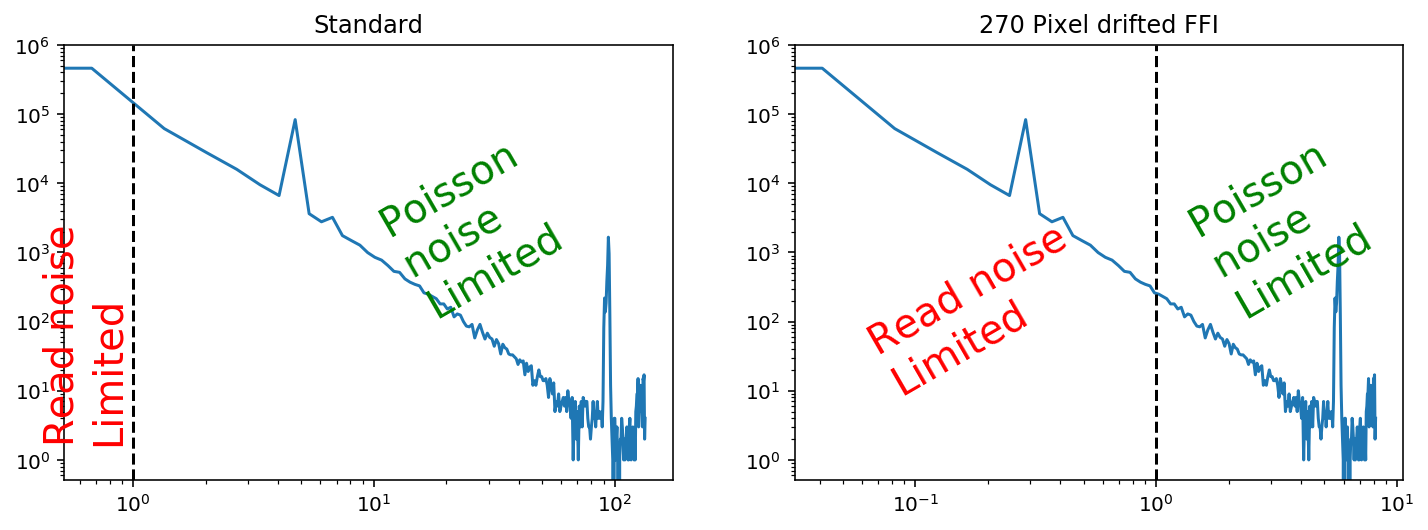

In [35]:
plt.figure(figsize=(12, 4))

vals = np.sqrt(np.abs(rate))/np.std(flat_bkg)
vmin, vmax = np.min(vals), np.max(vals)
x = np.linspace(vmin, vmax, 200)
y = histogram1d(vals.reshape(-1), bins=200, range=(vmin, vmax))

plt.subplot(121)
plt.plot(x, y)
plt.yscale('log')
plt.xscale('log')
plt.axvline(1, color='k', linestyle='dashed')
plt.text(10.0, 1.0E3, 'Poisson \nnoise \nLimited', fontsize=20, rotation=30, color='g');
plt.text(0.42, 3.0E2, 'Read noise \nLimited', fontsize=20, rotation=90, color='r')
plt.title('Standard');


vals = np.sqrt(np.abs(rate_mu))/np.std(flat_bkg)
vmin, vmax = np.min(vals), np.max(vals)
x = np.linspace(vmin, vmax, 200)
y = histogram1d(vals.reshape(-1), bins=200, range=(vmin, vmax))

plt.subplot(122)
plt.plot(x, y)
plt.yscale('log')
plt.xscale('log')
plt.axvline(1, color='k', linestyle='dashed')
plt.text(1.3, 1.0E3, 'Poisson \nnoise \nLimited', fontsize=20, rotation=30, color='g');
plt.text(0.06, 3.0E2, 'Read noise \nLimited', fontsize=20, rotation=30, color='r')
plt.title('270 Pixel drifted FFI');

Basically, more pixels are readnoise dominated in a drift-scan mode.  The threshold moves by a factor of:

In [36]:
np.sqrt(270)

16.431676725154983

## Drift mode, new slow rate: 0.1 deg / hr

Neat! Stars and some artifacts.

In [38]:
250*12

3000

In [41]:
0.1/4

0.025

What does the above image look like if the telescope is drifing through the sky?

Assume the drift rate is: 
$$\omega_d = \dot \theta = 0.1^{\circ} /\mathrm{hour}$$

$$= 0.1^{''} /\mathrm{sec}$$
$$= 0.025 \;\mathrm{pixels}/\mathrm{sec}$$

Kepler possesses both photon accumulation time and a read time:  

$$t_{int} = 6.02 \;\mathrm{sec}$$
$$t_{read} = 0.52 \;\mathrm{sec}$$

$t_{int}$ is the photon accumulation time per frame, while $t_{read}$ is the readout time per frame.

So with $0.5^{\circ} /\mathrm{hour}$ motion, we will have:
$$0.025 \; \frac{\mathrm{pixels}}{\mathrm{sec}} \times 6.54 \; \frac{\mathrm{sec}}{1}$$  
$$0.1635 \; \frac{\mathrm{pixels}}{\mathrm{frame}}$$  

There are 270 frames per net FFI exposure, yielding the 29.4 minute cadence we are used to.

In [42]:
0.025*6.54

0.1635

In [39]:
270.0*6.54/60

29.43

During the 270 frame exopsure, the *net drift* is about 220 pixels:

In [43]:
0.1635*270.0

44.145

Storing and reading out the FFI to the Solid State Recorder (SSR) takes about 15-20 minutes (priv. comm. from Marcie Smith and Doug Caldwell).  That's a shutter open time duty cycle of about:

In [44]:
29.4/(29.4+20)

0.5951417004048583

In [46]:
0.025*20*60.0

30.0

Realistically what this means is that frames will have 44-pixel-long streaks interrupted by an equivalent 30-pixel-long gap in data.

In [47]:
t_int = 6.02
t_read = 0.52

Simulate movement in both $x$ and $y$:

In [48]:
omega_x, omega_y = np.sqrt(2)*0.025, np.sqrt(2)*0.025

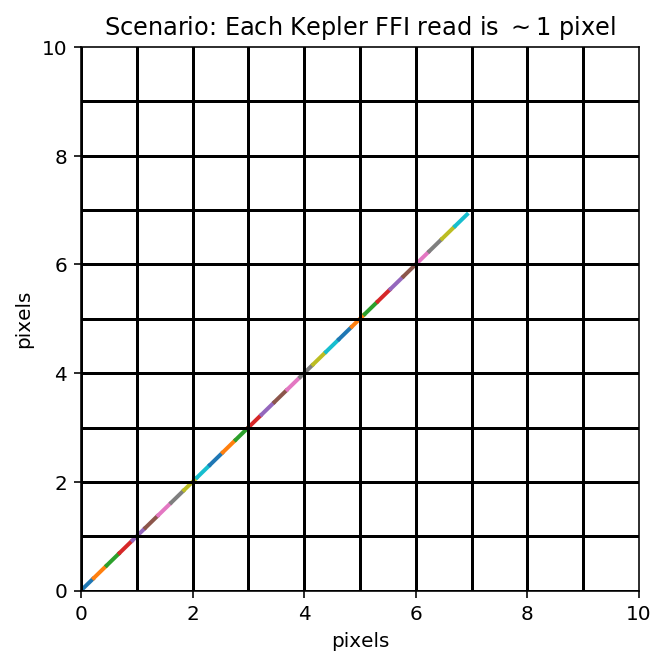

In [50]:
t0, t1, t2 = 0, 6.02, 6.54
x0, y0 = omega_x*t0, omega_y*t0
x1, y1 = omega_x*t1, omega_y*t1
x2, y2 = omega_x*t2, omega_y*t2

plt.figure(figsize=(5,5))

for frame_num in range(30):
    plt.plot([x0, x1], [y0, y1], lw = 2)    
    t0, t1 = t0+t2, t1+t2
    x0, y0 = omega_x*t0, omega_y*t0
    x1, y1 = omega_x*t1, omega_y*t1

for i in range(10):
    plt.axvline(i, color='k')
    plt.axhline(i, color='k')

plt.xlabel('pixels')
plt.ylabel('pixels')
plt.xlim(0,10)
plt.ylim(0,10)
plt.title('Scenario: Each Kepler FFI read is $\sim$1 pixel');

# Simulate the image motion

Let's round the image motion to the nearest integer to make our simulation computationally easier, otherwise we'd have to interpolate on a sub-pixel level. $$0.16 \; \frac{\mathrm{pixels}}{\mathrm{frame}} < 1 \frac{\mathrm{pixel}}{\mathrm{frame}}$$  

In [52]:
from skimage import transform

In [54]:
0.16**-1

6.25

In [53]:
dat.shape

(1070, 1132)

In [59]:
scale_up = 6
orig_x, orig_y = dat.shape
new_x, new_y = orig_x*scale_up, orig_y*scale_up

In [61]:
new_x, new_y

(6420, 6792)

In [67]:
new_dat = transform.resize(dat, (new_x, new_y), preserve_range=True, mode='constant')

In [69]:
rolled = new_dat*0.0

In [71]:
rate = (new_dat - 336.0)
rate_mu = np.abs(rate / 270.0)

In [72]:
npix = 270
for i in range(npix):
    del_roll = np.roll(np.roll(new_dat, i, 0), i,1)/270.0
    #del_nois = np.roll(np.roll(poisson.rvs(rate_mu), i, 0), i,1)
    rolled = rolled + del_roll #+ del_nois

In [73]:
logrolled = np.log10(rolled)

/Users/obsidian/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in log10
  """Entry point for launching an IPython kernel.


In [75]:
vmin, vmax = minmax.get_limits(logrolled[logrolled==logrolled])
vmin, vmax

(-3.824306028607813, 4.2716373957618936)

In [76]:
x = np.linspace(vmin, vmax, 200)
y = histogram1d(logrolled.reshape(-1), bins=200, range=(vmin, vmax))

In [77]:
good_interval = astropy.visualization.AsymmetricPercentileInterval(10, 60.0)
vmin, vmax = good_interval.get_limits(logrolled)

norm = astropy.visualization.ImageNormalize(vmin=10**vmin, vmax=10**vmax)

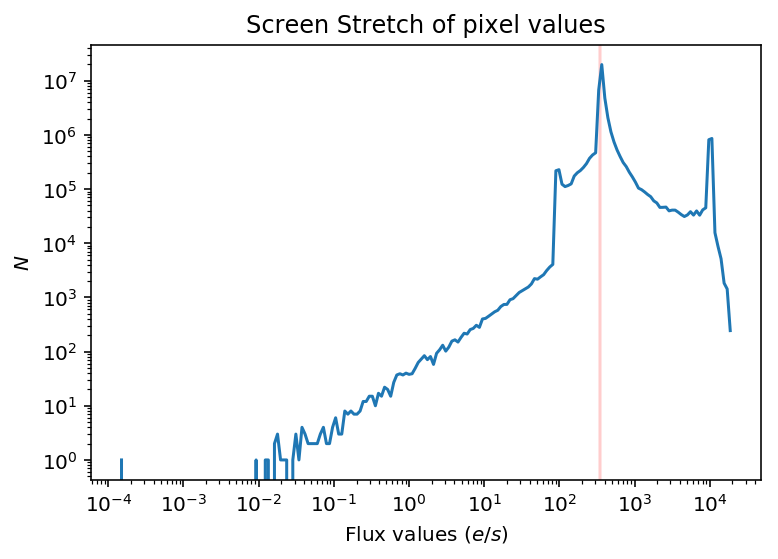

In [78]:
plt.plot(10**x, y)
plt.axvspan(10**vmin, 10**vmax, alpha=0.1, color='r')
plt.yscale('log')
plt.xscale('log')
plt.xlabel('Flux values ($e/s$)')
plt.ylabel('$N$')
plt.title('Screen Stretch of pixel values');

In [80]:
roll_dat = rolled[270:-50, 270:-50]

In [81]:
plt.figure(figsize=(15,15))
plt.imshow(roll_dat, norm=norm)
plt.title('Simulation of 270 pixel motion in a portion of an FFI')
plt.xlabel('pixels')
plt.ylabel('pixels')
#plt.savefig('./TWSDDL_motion_270pix_FFI_mod13p2_orig.png', dpi=300,bbox_inches='tight');

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.


Now with noise:

In [55]:
noisey_roll = roll_dat + flat_bkg

In [56]:
#good_interval = astropy.visualization.AsymmetricPercentileInterval(10, 60.0)
#vmin, vmax = good_interval.get_limits(np.log10(noisey_roll))

#norm = astropy.visualization.ImageNormalize(vmin=10**vmin, vmax=10**vmax)

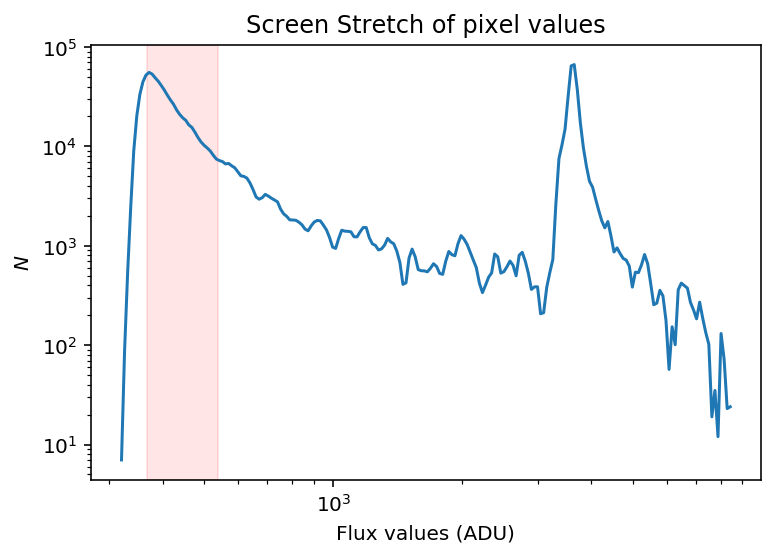

In [57]:
plt.plot(10**x, y)
plt.axvspan(10**vmin, 10**vmax, alpha=0.1, color='r')
plt.yscale('log')
plt.xscale('log')
plt.xlabel('Flux values (ADU)')
plt.ylabel('$N$')
plt.title('Screen Stretch of pixel values');

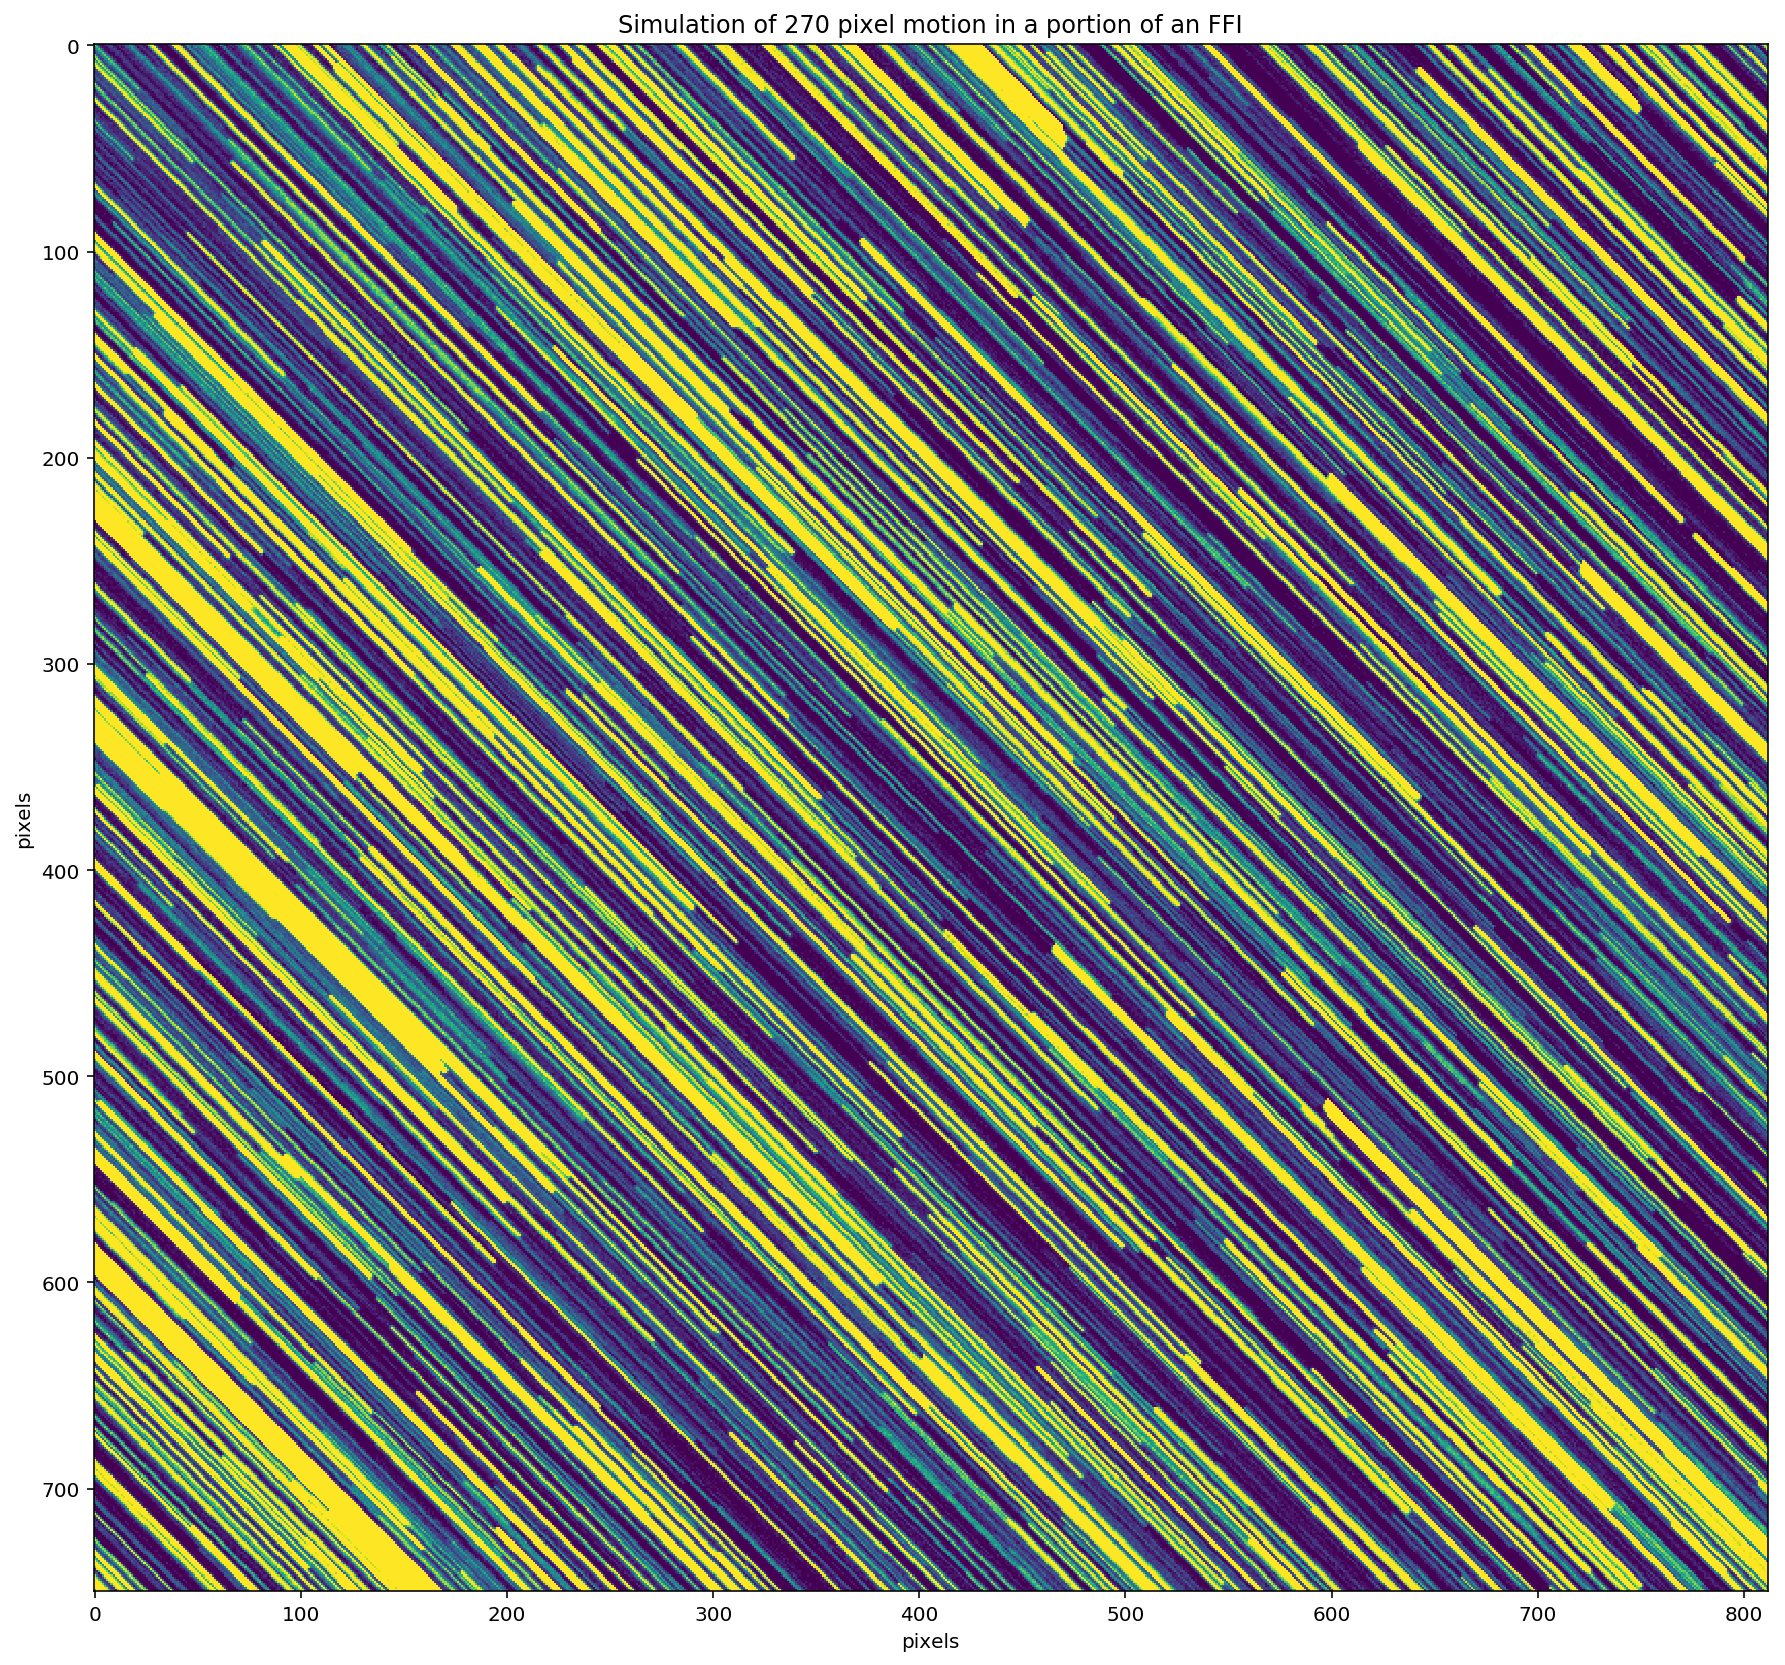

In [58]:
plt.figure(figsize=(15,15))
plt.imshow(noisey_roll, norm=norm)
plt.title('Simulation of 270 pixel motion in a portion of an FFI')
plt.xlabel('pixels')
plt.ylabel('pixels')
#plt.savefig('./TWSDDL_motion_270pix_FFI_mod13p2_nois.png', dpi=300,bbox_inches='tight');

Lots of motion, but that can be helpful from a flat-fielding perspective.

## $S/N$ ratio stats on the frames

In [61]:
n_frames = 270

frame_set = np.zeros((dim_x, dim_y, n_frames))
sum_set = np.zeros((dim_x, dim_y, n_frames))

for i in range(n_frames):
    flat_bkg = 0.0 + RN_per_read*np.random.randn(dim_x, dim_y)
    del_roll = np.roll(np.roll(dat, i, 0), i,1)
    frame_set[:,:, i] = flat_bkg + (del_roll[270:-50, 270:-50]-336)/270.0
    sum_set[:,:, i] = frame_set[:,:,0:i].sum(axis=2)

In [62]:
final_im = sum_set[:,:,-1]

In [63]:
sig_noise = final_im/3.5

In [64]:
minmax = astropy.visualization.MinMaxInterval()

vec = np.abs(sig_noise).reshape(-1)

vmin, vmax = minmax.get_limits(vec)

x = np.linspace(vmin, vmax, 200)
y = histogram1d(vec, bins=200, range=(vmin, vmax))

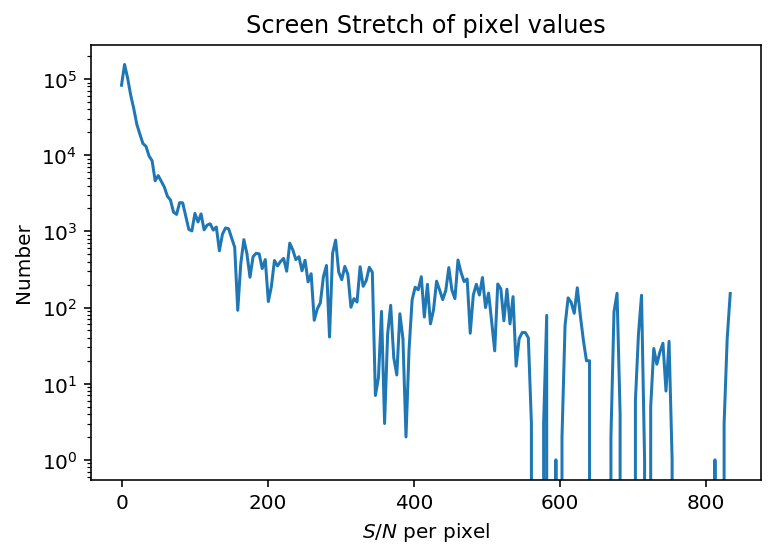

In [65]:
plt.plot(x, y)
plt.yscale('log')
plt.xlabel('$S/N$ per pixel')
plt.ylabel('Number')
plt.title('Screen Stretch of pixel values');

What we want is the *cumulative* distribution.

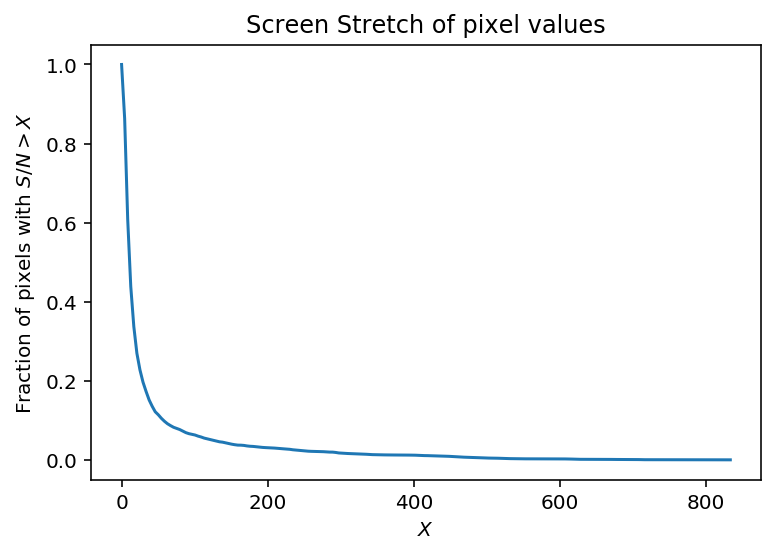

In [66]:
plt.plot(x[::-1], np.cumsum(y[::-1])/y.sum())
plt.xlabel('$X$')
plt.ylabel('Fraction of pixels with $S/N > X$')
plt.title('Screen Stretch of pixel values');

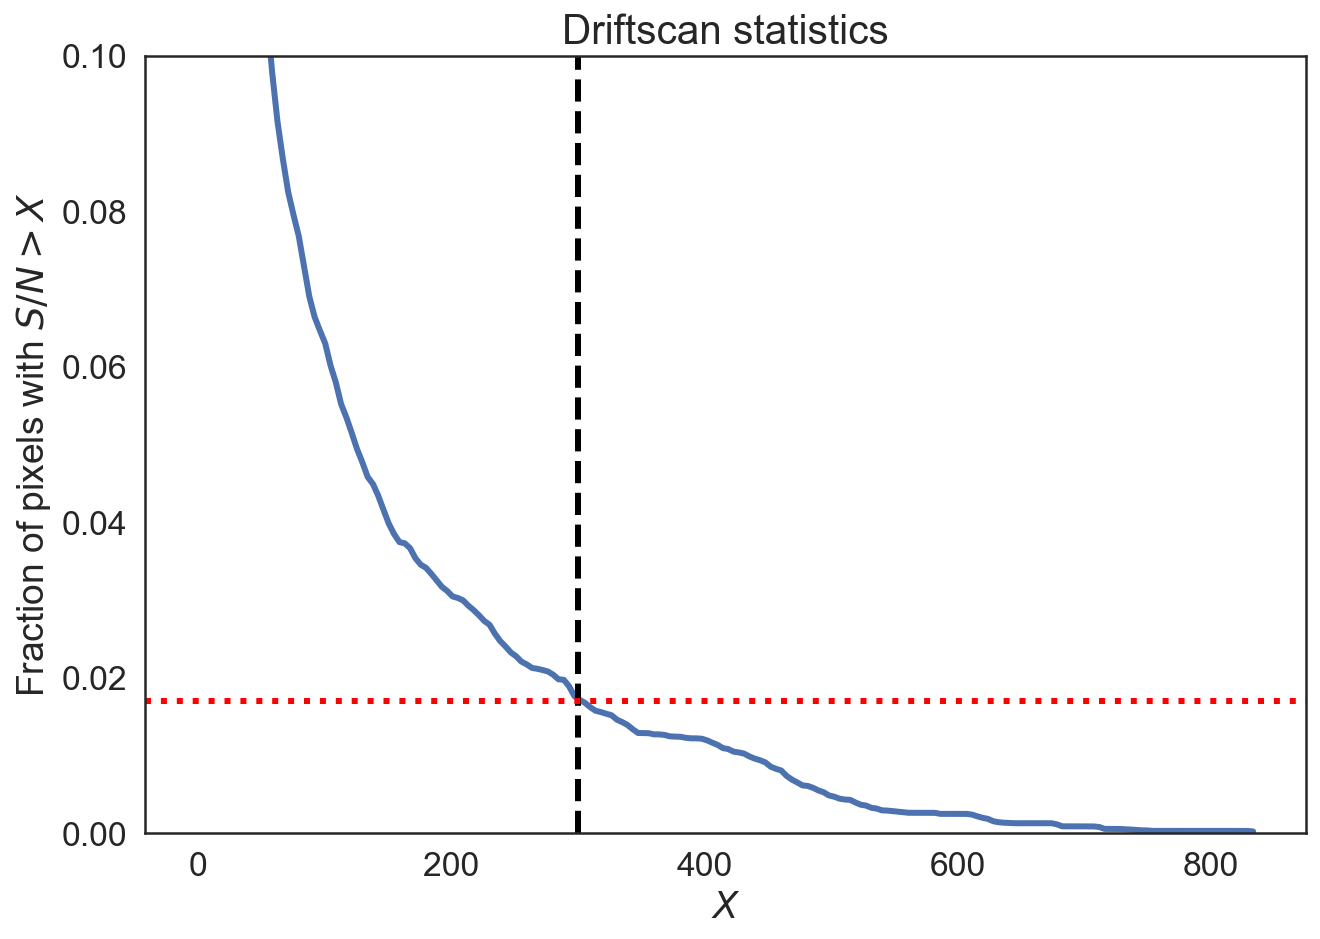

In [179]:
plt.plot(x[::-1], np.cumsum(y[::-1])/y.sum())
plt.xlabel('$X$')
plt.axvline(300, color='k', linestyle='dashed')
plt.axhline(0.017, color='r', linestyle='dotted')
plt.ylim(0, 0.1)
plt.ylabel('Fraction of pixels with $S/N > X$')
plt.title('Driftscan statistics');

It looks like $\sim1.7\%$ of pixels can be calibrated with signal-to-noise ratio 300 or better.  We're *not* including Poisson noise limit, which will limit $S/N$ to about 200 anyways.

In [68]:
np.percentile(vec, (5, 50, 95))

array([   2.35403005,   10.72157783,  123.58395942])

Hmm... so the median signal to noise ratio is 10.  Not great.  We need at least signal-to-noise ratio of 300 to get a 3 sigma detection of a 1% flat field variation.

## Summary figure

Let's apply some simple scaling relationships to build up a summary figure.

In [131]:
df = pd.DataFrame()

In [132]:
n_vals = len(vec)

In [133]:
n_ffi = 100
bool_arr = np.zeros((n_vals, n_ffi))
sum_bool = bool_arr.copy()

In [134]:
successes = np.int(0.017*len(vec))

In [135]:
for i in range(n_ffi):
    si = np.random.randint(0, n_vals, size=successes)
    bool_arr[si, i] = 1
    sum_bool[:, i] = np.any(bool_arr, axis=1)

In [136]:
frac_calibed = sum_bool.sum(axis=0)/n_vals

In [137]:
df['N_ffi'] = np.arange(1, n_ffi+1)
df['perc_pix_calibrated'] = frac_calibed

In [171]:
import seaborn as sns

In [172]:
sns.set_context('talk', font_scale=1.3, rc={"lines.linewidth": 3})
sns.set_style('white')

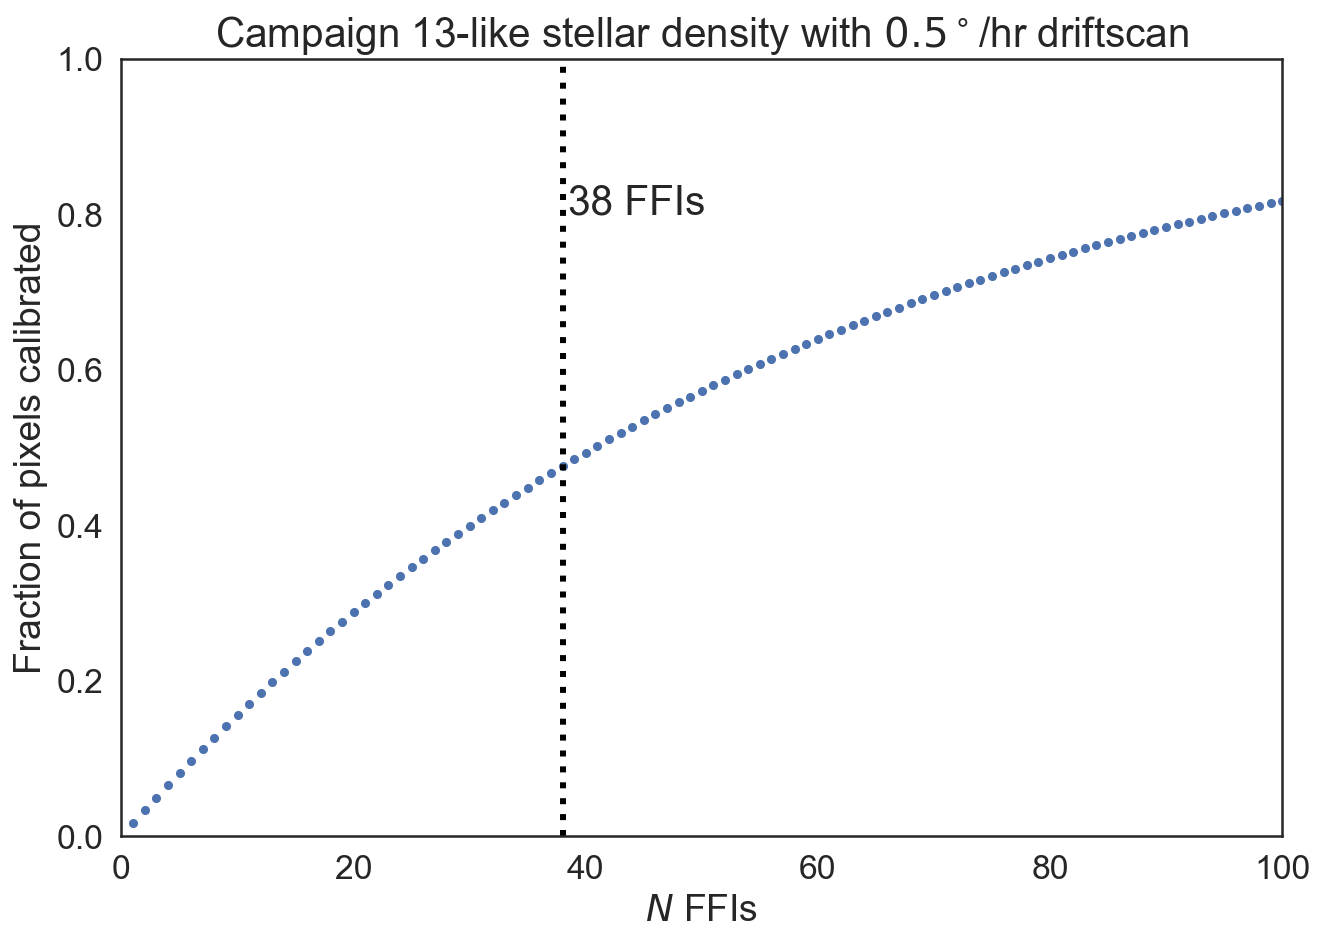

In [177]:
plt.plot(df.N_ffi, df.perc_pix_calibrated, '.')
plt.ylim(0, 1)
plt.xlim(0, 100)
plt.axvline(38, color='k', linestyle='dotted')
plt.text(38.5, 0.8, '38 FFIs')
plt.ylabel('Fraction of pixels calibrated')
plt.xlabel('$N$ FFIs')
plt.title('Campaign 13-like stellar density with $0.5^\circ$/hr driftscan')
plt.savefig('driftscan_EOL.png', dpi=300);

In [178]:
! open driftscan_EOL.png

## Easter Egg